<a href="https://colab.research.google.com/github/VTNay/MEC557-Project/blob/Zhichuan-MA/MEC557_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Project: Weather station

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/map.png?raw=1" width=400>

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris

### Data set

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/annual_temperature.png?raw=1" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

### First steps

- Look at the correlations between variables.
- What variable do I want to predict
- What time scale am interested in?
- Start with the easy predictions and move on to harder ones
- Are there events that are more predictable than others?

<ipython-input-28-2bfc7b127546>:32: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  paris_t2m_scaled = mmscaler.fit_transform(paris_t2m['2000'])
<ipython-input-28-2bfc7b127546>:39: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  london_d2m_scaled = mmscaler.fit_transform(london_d2m['2000'])
<ipython-input-28-2bfc7b127546>:47: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  london_t2m_scaled = mmscaler.fit_transform(london_t2m['2000'])
<ipython-input-28-2bfc7b127546>:56: FutureWarning: Indexing 

,Variables,R_cort2m_Paris
0,d2m,0.866857
1,t2m,1.000000
2,blh,0.379216
3,skt,0.972195
4,sp,-0.091366
5,ssrd,0.518303
6,tcc,-0.054926
7,tp,0.020438
8,u10,0.042646
9,v10,0.039966


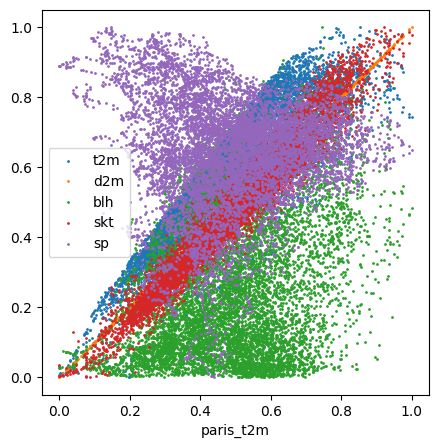

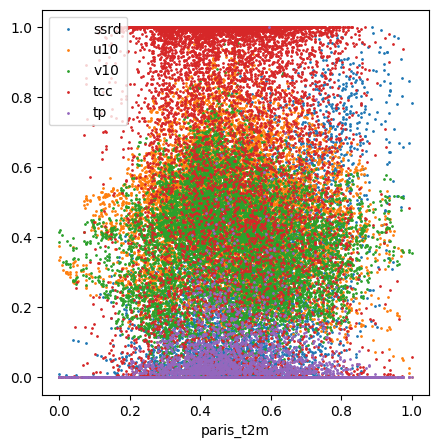

In [28]:
from pathlib import Path
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from sklearn import preprocessing

paris_path = Path('/content/drive/My Drive/PHY557_Project/weather/paris')
brest_path = Path('/content/drive/My Drive/PHY557_Project/weather/paris')
london_path = Path('/content/drive/My Drive/PHY557_Project/weather/paris')
marseile_path = Path('/content/drive/My Drive/PHY557_Project/weather/paris')
berlin_path = Path('/content/drive/My Drive/PHY557_Project/weather/paris')

#dir0 = Path('../../../data/projects/weather/paris/')
file_t2m = 't2m.nc'
file_blh = 'blh.nc'
file_d2m = 'd2m.nc'
file_skt = 'skt.nc'
file_sp = 'sp.nc'
file_ssrd = 'ssrd.nc'
file_tcc = 'tcc.nc'
file_tp = 'tp.nc'
file_u10 = 'u10.nc'
file_v10 = 'v10.nc'
#Normalize the variables
mmscaler = preprocessing.MinMaxScaler()

paris_t2m = xr.open_dataset(Path(paris_path, file_t2m))
# convert to pandas dataframe
paris_t2m = paris_t2m.to_dataframe()
# remove latitude and longitude indices
paris_t2m = paris_t2m.droplevel([0,1])
paris_t2m_scaled = mmscaler.fit_transform(paris_t2m['2000'])



london_d2m = xr.open_dataset(Path(london_path, file_d2m))
london_d2m = london_d2m.to_dataframe()
london_d2m = london_d2m.droplevel([1,2])
london_d2m_scaled = mmscaler.fit_transform(london_d2m['2000'])

corr_london_t2m_d2m = paris_t2m['t2m'].corr(london_d2m['d2m'])


london_t2m = xr.open_dataset(Path(london_path, file_t2m))
london_t2m = london_t2m.to_dataframe()
london_t2m = london_t2m.droplevel([0,1])
london_t2m_scaled = mmscaler.fit_transform(london_t2m['2000'])

corr_london_t2m_t2m = paris_t2m['t2m'].corr(london_t2m['t2m'])



london_blh = xr.open_dataset(Path(london_path, file_blh))
london_blh = london_blh.to_dataframe()
london_blh = london_blh.droplevel([1,2])
london_blh_scaled = mmscaler.fit_transform(london_blh['2000'])

corr_london_t2m_blh = paris_t2m['t2m'].corr(london_blh['blh'])



london_skt = xr.open_dataset(Path(london_path, file_skt))
london_skt = london_skt.to_dataframe()
london_skt = london_skt.droplevel([0,1])
london_skt_scaled = mmscaler.fit_transform(london_skt['2000'])

corr_london_t2m_skt = paris_t2m['t2m'].corr(london_skt['skt'])


london_sp = xr.open_dataset(Path(london_path, file_sp))
london_sp = london_sp.to_dataframe()
london_sp = london_sp.droplevel([0,1])
london_sp_scaled = mmscaler.fit_transform(london_sp['2000'])

corr_london_t2m_sp= paris_t2m['t2m'].corr(london_sp['sp'])


london_ssrd = xr.open_dataset(Path(london_path, file_ssrd))
london_ssrd = london_ssrd.to_dataframe()
london_ssrd = london_ssrd.droplevel([0,1])
london_ssrd_scaled = mmscaler.fit_transform(london_ssrd['2000'])

corr_london_t2m_ssrd = paris_t2m['t2m'].corr(london_ssrd['ssrd'])


london_tcc = xr.open_dataset(Path(london_path, file_tcc))
london_tcc = london_tcc.to_dataframe()
london_tcc = london_tcc.droplevel([0,1])
london_tcc_scaled = mmscaler.fit_transform(london_tcc['2000'])

corr_london_t2m_tcc = paris_t2m['t2m'].corr(london_tcc['tcc'])

london_tp = xr.open_dataset(Path(london_path, file_tp))
london_tp = london_tp.to_dataframe()
london_tp = london_tp.droplevel([0,1])
london_tp_scaled = mmscaler.fit_transform(london_tp['2000'])

corr_london_t2m_tp = paris_t2m['t2m'].corr(london_tp['tp'])

london_u10 = xr.open_dataset(Path(london_path, file_u10))
london_u10 = london_u10.to_dataframe()
london_u10 = london_u10.droplevel([0,1])
london_u10_scaled = mmscaler.fit_transform(london_u10['2000'])

corr_london_t2m_u10 = paris_t2m['t2m'].corr(london_u10['u10'])

london_v10 = xr.open_dataset(Path(london_path, file_v10))
london_v10 = london_v10.to_dataframe()
london_v10 = london_v10.droplevel([0,1])
london_v10_scaled = mmscaler.fit_transform(london_v10['2000'])

corr_london_t2m_v10 = paris_t2m['t2m'].corr(london_v10['v10'])

plt.figure(figsize = (5,5))
plt.scatter(paris_t2m_scaled, london_d2m_scaled , s = 1, label = 't2m')
plt.scatter(paris_t2m_scaled, london_t2m_scaled, s = 1, label = 'd2m')
plt.scatter(paris_t2m_scaled, london_blh_scaled, s = 1, label = 'blh')
plt.scatter(paris_t2m_scaled, london_skt_scaled, s = 1, label = 'skt')
plt.scatter(paris_t2m_scaled, london_sp_scaled, s = 1, label = 'sp')
plt.xlabel('paris_t2m')
plt.legend()

plt.figure(figsize = (5,5))
plt.scatter(paris_t2m_scaled, london_ssrd_scaled, s = 1, label = 'ssrd')
plt.scatter(paris_t2m_scaled, london_u10_scaled, s = 1, label = 'u10')
plt.scatter(paris_t2m_scaled, london_v10_scaled, s = 1, label = 'v10')
plt.scatter(paris_t2m_scaled, london_tcc_scaled, s = 1, label = 'tcc')
plt.scatter(paris_t2m_scaled, london_tp_scaled, s = 1, label = 'tp')
plt.xlabel('paris_t2m')
plt.legend()

corr_london_total = {
    'Variables': ['d2m', 't2m', 'blh', 'skt', 'sp', 'ssrd', 'tcc', 'tp', 'u10', 'v10'],
    'R_cort2m_Paris': [corr_london_t2m_d2m, corr_london_t2m_t2m, corr_london_t2m_blh, corr_london_t2m_skt, corr_london_t2m_sp, corr_london_t2m_ssrd, corr_london_t2m_tcc, corr_london_t2m_tp, corr_london_t2m_u10, corr_london_t2m_v10],
}
df_corr_london_total = pd.DataFrame(corr_london_total)
df_corr_london_total


***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_lmd.jpg?raw=1" style="display: inline-block"/>

<img alt="Logo IPSL" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ipsl.png?raw=1" style="display: inline-block"/>

<img alt="Logo E4C" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_e4c_final.png?raw=1" style="display: inline-block"/>

<img alt="Logo EP" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ep.png?raw=1" style="display: inline-block"/>

<img alt="Logo SU" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_su.png?raw=1" style="display: inline-block"/>

<img alt="Logo ENS" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ens.jpg?raw=1" style="display: inline-block"/>

<img alt="Logo CNRS" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_cnrs.png?raw=1" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>